<h1></h1>
<h1 align="center">Hurricane CNN model</h1>
<h2 align="center">Deborah Ugaldes & George Whittington</h2>
<h3 align="center">April 17th, 2025</h3>
<hr>

In [1]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os

In [2]:
DATA_DIR = "Data"
BATCH_SIZE = 32
IMAGE_SIZE = (128,128)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using CUDA


In [3]:
def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    """Plots a confusion matrix as a heatmap."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

def plot_roc_curve(all_labels, all_probs, title="ROC Curve"):
    """Plots the ROC curve."""
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.plot([0, 1], [0, 1], "k--", label="Random Guessing")  # Diagonal line for random classifier
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.show()

def evaluate_model(model, dataloader, device, class_names):
    """Evaluates the model and returns various metrics."""
    model.eval()  # Set to evaluation mode
    all_preds = []
    all_labels = []
    all_probs = [] # Store probabilities for AUC-ROC

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = F.softmax(outputs, dim=1) # Convert logits to probabilities
            _, predicted = torch.max(outputs, 1)


            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy()) # Store for AUC-ROC

    # Convert to numpy arrays for scikit-learn
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Calculate metrics
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)
    plot_confusion_matrix(cm, class_names, title="Confusion Matrix")

    try:
        auc_roc = roc_auc_score(all_labels, all_probs[:, 1]) # AUC for class 1
        print(f"AUC-ROC: {auc_roc:.4f}")
        plot_roc_curve(all_labels, all_probs, title="ROC Curve")

    except ValueError:
        print("AUC-ROC not calculated: Only one class present in y_true.") # Handle case where only one class is present
        auc_roc = None

    accuracy = np.mean(all_preds == all_labels)
    print(f"Accuracy: {accuracy:.4f}")

    return cm, all_labels, all_probs

In [4]:
!unzip -q Data

In [5]:
# Load the dataset: using train set to avoid data leakage and integrity of the model evaluation process
dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=transforms.ToTensor())

# Create a dataloader
dataloader = DataLoader(dataset, batch_size=256, shuffle=False, num_workers=2)

# Calculate mean and std
mean = torch.zeros(3).to(device)
std = torch.zeros(3).to(device)
total_images = 0

# Load all the training images
for images, _ in dataloader:
    # move tensors to GPU
    images = images.to(device)

    batch_size = images.size(0)
    images = images.view(batch_size, images.size(1), -1)

    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images += batch_size

# put in correct format for transforms.Normalize
mean = (mean/total_images).tolist()
std = (std/total_images).tolist()

In [6]:
# I believe all the images are already formatted to 128x128 pixels, but just in case
transform = {
    'train': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'validation': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test_another': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

In [7]:
image_datasets = {}
dataloaders = {}

for folder in ['train', 'validation', 'test', 'test_another']:
    # here we load/apply the transform to all the images in the current folder
    image_datasets[folder] = datasets.ImageFolder(os.path.join(DATA_DIR, folder), transform[folder])

    # here we create data loaders for the current folder
    dataloaders[folder] = DataLoader(image_datasets[folder], batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [8]:
# validate all the images are loaded
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test', 'test_another']}
print(f"Dataset sizes: {dataset_sizes}\n")

# validate class names
class_names = image_datasets['train'].classes
print(f"Class names: {class_names}\n")

# validate tensors are proper size
t, _ = image_datasets["train"][0]
print(t.size())

Dataset sizes: {'train': 10000, 'validation': 2000, 'test': 2000, 'test_another': 9000}

Class names: ['damage', 'no_damage']

torch.Size([3, 128, 128])


In [9]:
class HurricaneCNN(nn.Module):
    def __init__(self, kernel_size=3, stride=1):
        super().__init__()

        # take 2x2 pixels and make 1 pixel
        self.pool = nn.MaxPool2d(2, 2)

        # set up convolutional layers
        self.covn1 = nn.Conv2d(in_channels=3, out_channels=32, # (32, 126, 126)
                               kernel_size=kernel_size, stride=stride) # (32, 63, 63)

        self.covn2 = nn.Conv2d(in_channels=32, out_channels=64, # (64, 61, 61)
                               kernel_size=kernel_size, stride=stride) # (64, 30, 30)

        self.covn3 = nn.Conv2d(in_channels=64, out_channels=128, # (128, 28, 28)
                               kernel_size=kernel_size, stride=stride) # (128, 14, 14)

        self.covn4 = nn.Conv2d(in_channels=128, out_channels=256, # (256, 12, 12)
                               kernel_size=kernel_size, stride=stride) # (256, 6, 6)

        # 128 is the initial image size
        self.flatten_num = (((((((128-kernel_size+1)//2) -kernel_size+1)//2) -kernel_size+1)//2) -kernel_size+1)//2

        # set up the fully connected layers
        self.fc1 = nn.Linear(in_features=256*self.flatten_num*self.flatten_num,
                             out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=2) # output 2 for binary classification

        # Move the all the layers to the GPU
        self.covn1.to(device)
        self.covn2.to(device)
        self.covn3.to(device)
        self.covn4.to(device)
        self.fc1.to(device)
        self.fc2.to(device)

    def forward(self, x):
        x = self.pool(F.relu(self.covn1(x)))
        x = self.pool(F.relu(self.covn2(x)))
        x = self.pool(F.relu(self.covn3(x)))
        x = self.pool(F.relu(self.covn4(x)))

        # flattening operation
        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [16]:
model = HurricaneCNN(kernel_size=3, stride=1).to(device)

loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)

Epoch 1/15
----------
train Loss: 0.3498 Acc: 0.8503
validation Loss: 0.2687 Acc: 0.8895
New best validation accuracy: 0.8895

Epoch 2/15
----------
train Loss: 0.1919 Acc: 0.9249
validation Loss: 0.1829 Acc: 0.9265
New best validation accuracy: 0.9265

Epoch 3/15
----------
train Loss: 0.1415 Acc: 0.9432
validation Loss: 0.1199 Acc: 0.9495
New best validation accuracy: 0.9495

Epoch 4/15
----------
train Loss: 0.1205 Acc: 0.9529
validation Loss: 0.1056 Acc: 0.9600
New best validation accuracy: 0.9600

Epoch 5/15
----------
train Loss: 0.1096 Acc: 0.9563
validation Loss: 0.1366 Acc: 0.9415
Validation accuracy did not improve

Epoch 6/15
----------
train Loss: 0.0960 Acc: 0.9644
validation Loss: 0.0966 Acc: 0.9670
New best validation accuracy: 0.9670

Epoch 7/15
----------
train Loss: 0.0826 Acc: 0.9686
validation Loss: 0.0895 Acc: 0.9690
New best validation accuracy: 0.9690

Epoch 8/15
----------
train Loss: 0.0697 Acc: 0.9753
validation Loss: 0.0864 Acc: 0.9680
Validation accuracy did

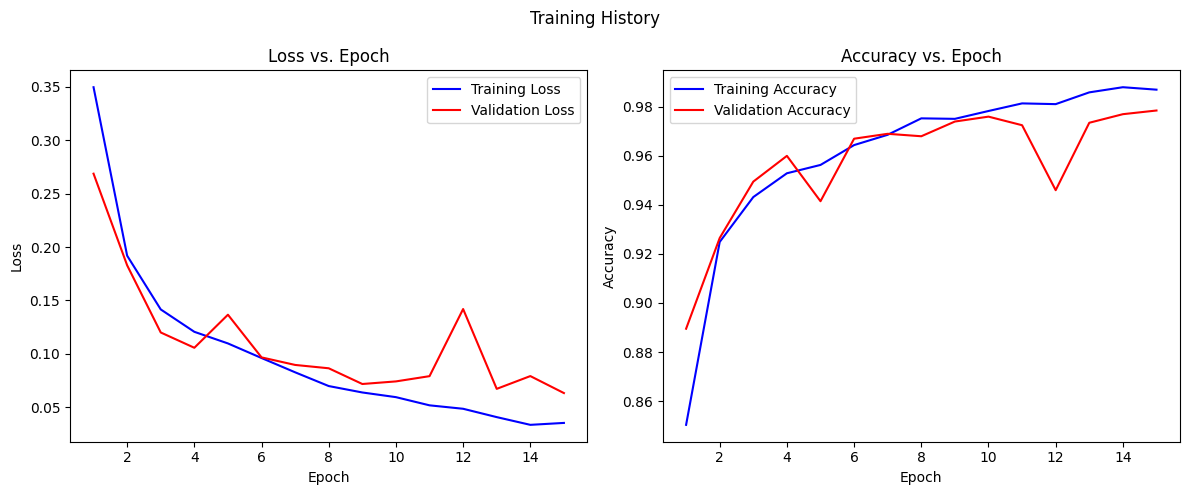

In [17]:
EPOCHS = 15
MAX_NO_IMPROVEMENT = 3

# tracking improvement to avoid overfitting
epochs_no_improve = 0

best_validation_accuracy = 0.0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print("-"*10)

    # stop early and load the best model weights
    if epochs_no_improve > MAX_NO_IMPROVEMENT:
        print ("Early stopping!")
        model.load_state_dict(torch.load("trained_model.pth"))
        break

    # utilizing both train and validation set to help avoid overfitting
    for phase in ["train", "validation"]:
        # set the model mode based on the phase
        if phase == "train":
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_correct = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # track history if only in train
            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)

                _, predicted = torch.max(outputs, 1)

                loss = loss_function(outputs, labels)

                # backward + optimize only if in training phase
                if phase == "train":
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_correct += torch.sum(predicted == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_accuracy = running_correct.float() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_accuracy:.4f}')

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_accuracy.item())  # Correctly store as a Python number
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_accuracy.item())  # Correctly store as a Python number

    # implementation of trying to avoid over fitting
    if phase == "validation":
        # save the model weights if this is the best so far
        if epoch_accuracy > best_validation_accuracy:
            best_validation_accuracy = epoch_accuracy

            torch.save(model.state_dict(), f"trained_model.pth")

            print(f'New best validation accuracy: {best_validation_accuracy:.4f}')
            epochs_no_improve = 0
        # limit time trining without improvement
        else:
            epochs_no_improve += 1
            print(f"Validation accuracy did not improve")

    # for output spacing
    print()

print("Finished Training")
print(f'Best validation accuracy: {best_validation_accuracy:.4f}')

# --- Plotting Training History ---
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.suptitle('Training History')
plt.tight_layout()
plt.show()

In [ ]:
model.load_state_dict(torch.load("trained_model.pth", map_location=torch.device('mps')))

<All keys matched successfully>

In [18]:
correct = 0
total = 0

model.eval()

with torch.no_grad():
    for data in dataloaders["test"]:
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy}%")

Accuracy: 98.3%


In [19]:
correct = 0
total = 0

model.eval()

with torch.no_grad():
    for data in dataloaders["test_another"]:
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy}%")

Accuracy: 98.45555555555555%


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1000
           1       0.99      0.98      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000

Confusion Matrix:
[[990  10]
 [ 24 976]]


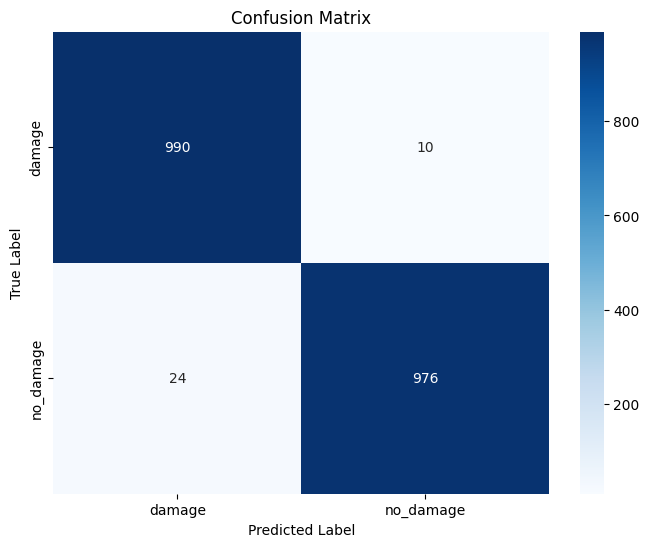

AUC-ROC: 0.9993


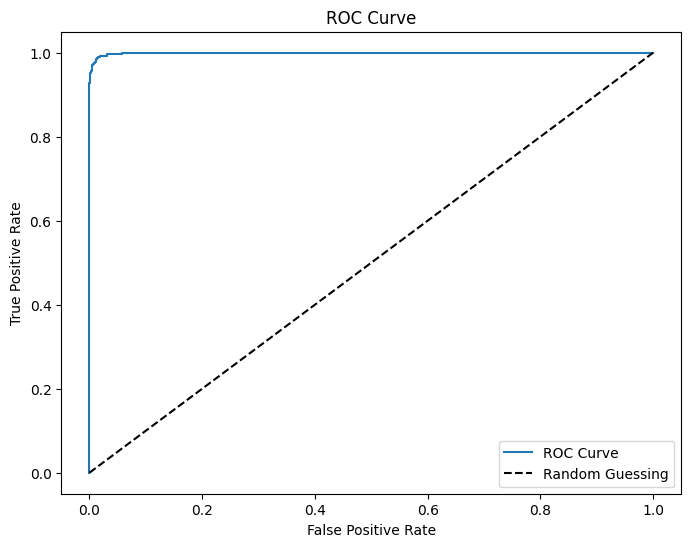

Accuracy: 0.9830


In [20]:
cm_test, all_labels_test, all_probs_test = evaluate_model(model, dataloaders["test"], device, class_names)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8000
           1       0.91      0.96      0.93      1000

    accuracy                           0.98      9000
   macro avg       0.95      0.97      0.96      9000
weighted avg       0.99      0.98      0.98      9000

Confusion Matrix:
[[7903   97]
 [  42  958]]


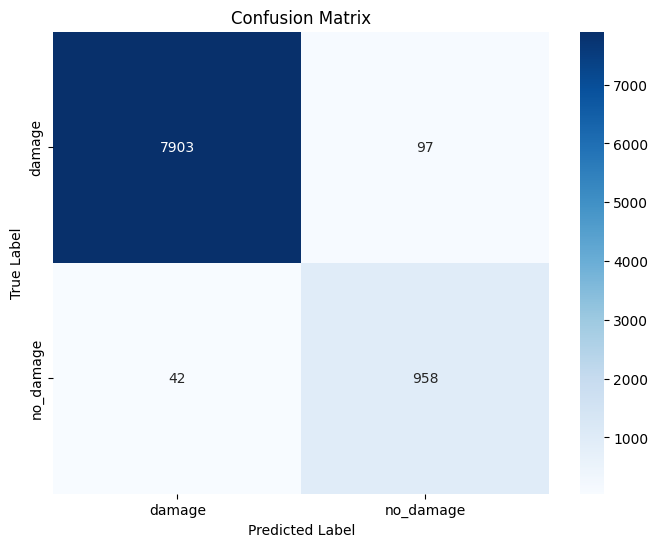

AUC-ROC: 0.9982


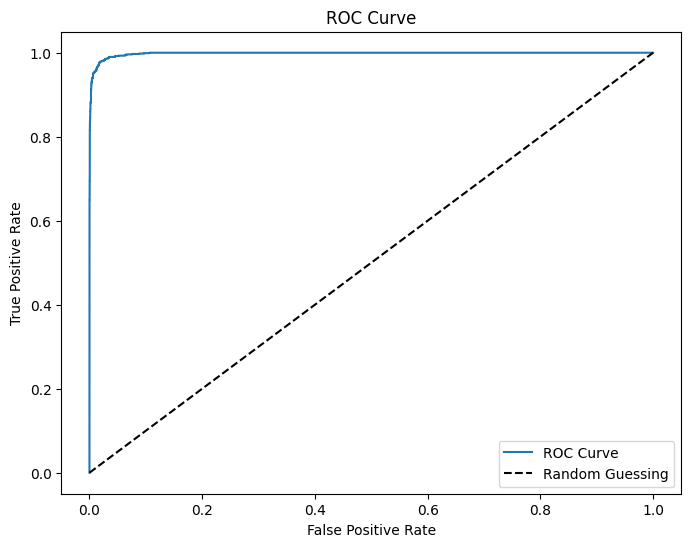

Accuracy: 0.9846


In [21]:
cm_another, all_labels_another, all_probs_another = evaluate_model(model, dataloaders["test_another"], device, class_names)